In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from battery_loader import load
import matplotlib.pyplot as plt  

In [3]:
DEVICE = "cuda:2" 
# Hyper params
LR = 1e-3
MAX_EPOCH = 20
BATCH_SIZE = 80 # one battery samples

In [4]:
df = load(1)
for i in range(2, 29):
    df = df.append(load(i), ignore_index=True)
print(df.count())
df.to_csv('data.csv', index=False)
df.head()

battery     950
time        950
capacity    950
dtype: int64


,battery,time,capacity
0,1,108.011922,2.000349
1,1,113.650886,2.000235
2,1,234.180336,1.958467
3,1,239.462672,1.963174
4,1,347.737075,1.911200


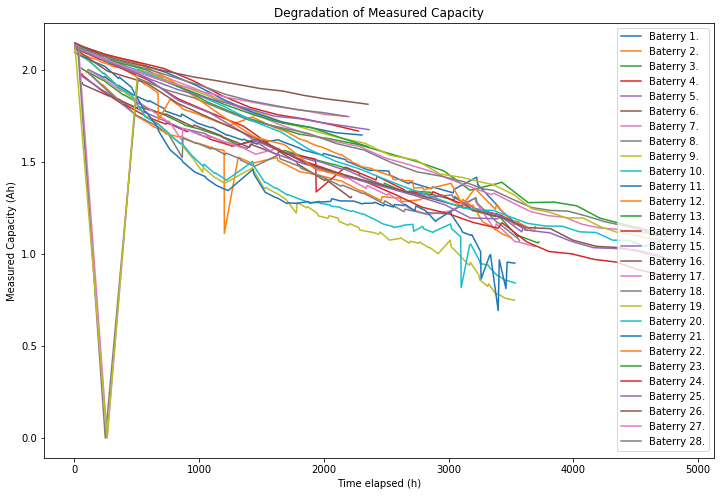

In [75]:
df = pd.read_csv('data.csv')

def plot_train_data():    
    plt.figure(figsize=(12,8))
    plt.title("Degradation of Measured Capacity")
    plt.xlabel("Time elapsed (h)")
    plt.ylabel("Measured Capacity (Ah)")
    for i in range (1, 29):
        plt.plot(df[df['battery']==i]['time'], df[df['battery']==i]['capacity'], label=f"Baterry {i}.")
    plt.legend()
    plt.show() 

plot_train_data()

In [76]:
# Data error?
print(df[df['capacity'] < .5])
df = df[df['capacity'] > .5]
df.count()
df.head()

     battery        time  capacity
745       17  262.649372       0.0
774       18  247.274825       0.0
801       19  261.465181       0.0


,battery,time,capacity
0,1,108.011922,2.000349
1,1,113.650886,2.000235
2,1,234.180336,1.958467
3,1,239.462672,1.963174
4,1,347.737075,1.911200


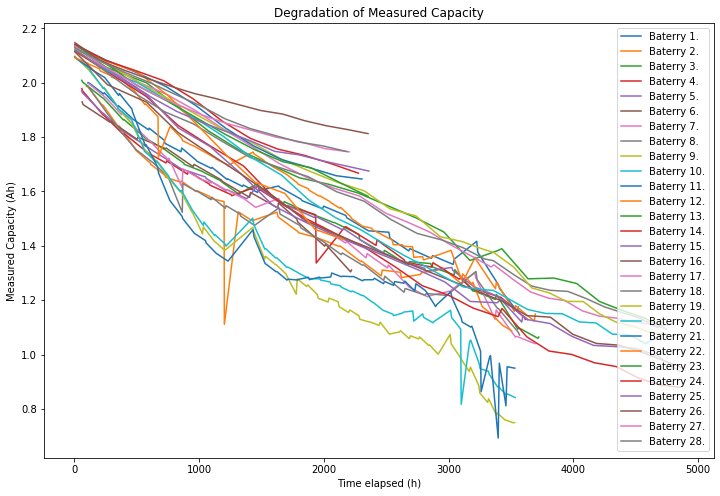

In [67]:
plot_train_data()

In [61]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print(df_train.count())
print(df_val.count())
df_train.head()

battery     757
time        757
capacity    757
dtype: int64
battery     190
time        190
capacity    190
dtype: int64


,battery,time,capacity
109,3,729.581661,1.752392
77,2,1961.285600,1.427313
549,11,2404.810403,1.280925
846,20,3496.992217,1.200832
82,2,2460.351978,1.289426


In [68]:
# Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        self.BatchNorm = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.BatchNorm(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.BatchNorm(x)
        return self.fc3(x)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.type(torch.float32).to(device), target.type(torch.float32).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target, reduction="mean")
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.4f}'.format(epoch, loss.item()))
            
                       
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.type(torch.float32).to(device), target.type(torch.float32).to(device)
            output = model(data)
            val_loss += F.mse_loss(output, target, reduction="mean")
    val_loss /= len(val_loader.dataset)
    print('Validation: Average loss: {:.4f}\n'.format(val_loss))            


In [69]:
time_train = torch.tensor(df_train['time'].values)
cap_train = torch.tensor(df_train['capacity'].values)

time_val = torch.tensor(df_val['time'].values)
cap_val = torch.tensor(df_val['capacity'].values)

train_loader = DataLoader(TensorDataset(time_train.unsqueeze(1), cap_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_loader = DataLoader(TensorDataset(time_val.unsqueeze(1), cap_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)

model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, MAX_EPOCH + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    validate(model, DEVICE, val_loader)

torch.save(model.state_dict(), "battery_capacity.pt")

Train Epoch: 1 	Loss: 3.7668
Validation: Average loss: 0.0619

Train Epoch: 2 	Loss: 1.5640
Validation: Average loss: 0.0375

Train Epoch: 3 	Loss: 1.7048
Validation: Average loss: 0.0351

Train Epoch: 4 	Loss: 1.3634
Validation: Average loss: 0.0162

Train Epoch: 5 	Loss: 1.0116
Validation: Average loss: 0.0222

Train Epoch: 6 	Loss: 0.7307
Validation: Average loss: 0.0113

Train Epoch: 7 	Loss: 0.7717
Validation: Average loss: 0.0117

Train Epoch: 8 	Loss: 0.3402
Validation: Average loss: 0.0069

Train Epoch: 9 	Loss: 0.2871
Validation: Average loss: 0.0063

Train Epoch: 10 	Loss: 0.2479
Validation: Average loss: 0.0038

Train Epoch: 11 	Loss: 0.1422
Validation: Average loss: 0.0028

Train Epoch: 12 	Loss: 0.1479
Validation: Average loss: 0.0018

Train Epoch: 13 	Loss: 0.1050
Validation: Average loss: 0.0015

Train Epoch: 14 	Loss: 0.0318
Validation: Average loss: 0.0009

Train Epoch: 15 	Loss: 0.0183
Validation: Average loss: 0.0009

Train Epoch: 16 	Loss: 0.0162
Validation: Average

In [70]:
print('Number of trainable params: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of trainable params: 1054721


In [77]:
# load model to cpu
model = Net()
model.load_state_dict(torch.load( "battery_capacity.pt"))
# model.to('cpu')
model.eval()

# take battery 11 for test
df = load(11)

# Prepare torch tensor (1,77) in floats for inference
time_torch_tensor = torch.tensor(df['time'].values).type(torch.float32).unsqueeze(1)
# To 1-dimensional Numpy array for graph
predicted_capacity  = model(time_torch_tensor).squeeze().detach().numpy()

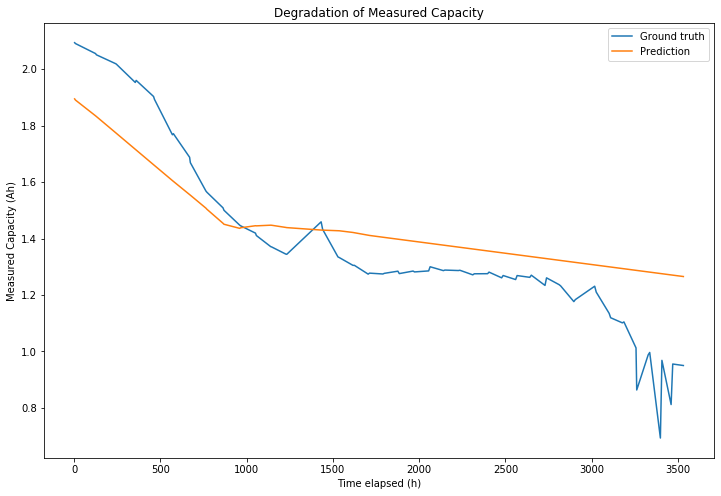

In [78]:
plt.figure(figsize=(12,8)) 
plt.title("Degradation of Measured Capacity")
plt.plot(df['time'], df['capacity'], label="Ground truth")
plt.plot(df['time'], predicted_capacity, label="Prediction")
plt.xlabel("Time elapsed (h)")
plt.ylabel("Measured Capacity (Ah)")
plt.legend()
plt.show()    